<h1>Skin detector</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras import backend as K
from keras.utils import np_utils
import os

TRAIN_PATH = '../datasets/skin_cancer/train'
TEST_PATH = '../datasets/skin_cancer/test'
#tensorflow = channel last
#theano = channel first
print(K.backend())
K.set_image_data_format(data_format='channels_last')

tensorflow


"The data consists of two folders with each <strong>1800</strong> pictures <strong>(224x224)</strong> of the two types of moles."</br>
<strong>The goal is to predict if a skin spot is either benign or malignant.</strong>

<h2>Building datasets</h2>

In [3]:
def create_array(train_test_path, benign_malign_path, width, height):
    complete_path = f'{train_test_path}/{benign_malign_path}/'
    X = np.empty(shape=(len(os.listdir(complete_path)), width, height)) #1440 images of 224x224 pixels in RGB but for computation reason we will use grayscale
    for i, image_file in enumerate(os.listdir(complete_path)):
        im = ImageOps.grayscale(Image.open(f'{complete_path}{image_file}')) #from (224, 224, 3) to (224, 224)
        X[i] = np.array(im)
    if benign_malign_path == 'benign':
        y = np.zeros(shape=X.shape[0])
    elif benign_malign_path == 'malignant':
        y = np.ones(shape=X.shape[0])
    else:
        print('benign_malign_path must be "benign" or "malign"')
    return X, y

def shuffle_in_unison(a, b):
    """
        Shuffle two array in the same order (see: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison)
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [4]:
X_train_benign, y_train_benign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='benign', width=224, height=224)
X_train_malign, y_train_malign = create_array(train_test_path=TRAIN_PATH, benign_malign_path='malignant', width=224, height=224)

In [5]:
X_test_benign, y_test_benign = create_array(train_test_path=TEST_PATH, benign_malign_path='benign', width=224, height=224)
X_test_malign, y_test_malign = create_array(train_test_path=TEST_PATH, benign_malign_path='malignant', width=224, height=224)

In [6]:
print(X_train_benign.shape, y_train_benign.shape)
print(X_train_malign.shape, y_train_malign.shape)

X_train = np.concatenate((X_train_benign, X_train_malign), axis=0)
y_train = np.concatenate((y_train_benign, y_train_malign), axis=0)
print(X_train.shape, y_train.shape)

(1440, 224, 224) (1440,)
(1197, 224, 224) (1197,)
(2637, 224, 224) (2637,)


In [7]:
print(X_test_benign.shape, y_test_benign.shape)
print(X_test_malign.shape, y_test_malign.shape)

X_test = np.concatenate((X_test_benign, X_test_malign), axis=0)
y_test = np.concatenate((y_test_benign, y_test_malign), axis=0)
print(X_test.shape, y_test.shape)

(360, 224, 224) (360,)
(300, 224, 224) (300,)
(660, 224, 224) (660,)


In [8]:
shuffle_in_unison(X_train, y_train)
shuffle_in_unison(X_test, y_test)

<h2>Processing data</h2>

In [9]:
def resize(X, y):
    X = X[:, :, :, np.newaxis]
    y = np.reshape(y, newshape=(y.shape[0], 1))
    return X, y

def rescale(X, y):
    X = X.astype('float32')
    return X/255, np_utils.to_categorical(y)

<h3>Resizing :</h3>

In [10]:
#we need a n * (width, height, 1) shape (channels_last)
X_train, y_train = resize(X_train, y_train)
X_test, y_test = resize(X_test, y_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2637, 224, 224, 1) (660, 224, 224, 1)
(2637, 1) (660, 1)


<h3>Rescaling :</h3>

In [ ]:
X_train, y_train = rescale(X_train, y_train)

In [11]:
X_test, y_test = rescale(X_test, y_test)

In [15]:
#X_train = X_train.astype("float32")
#X_train /= 255
#y_train = np_utils.to_categorical(y_train)

<h2>Modelling :</h2>

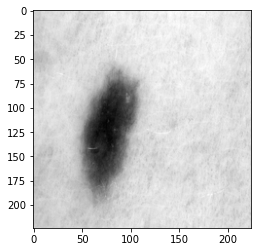

In [16]:
plt.imshow(X_test[0], cmap='gray')

In [17]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping

OPTIM = SGD()
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [21]:
class LeNet :
    def __init__(self, input_shape, num_class):
        self.model = Sequential()
        self.input_shape = input_shape
        self.num_class = num_class
        
    def build(self):
        self.model.add(Conv2D(filters=20, kernel_size=(7, 7), padding='same', input_shape=self.input_shape))
        self.model.add(Activation(activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.model.add(Dropout(0.3))
        
        self.model.add(Conv2D(filters=50, kernel_size=(7, 7), padding='same'))
        self.model.add(Activation(activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.model.add(Dropout(0.3))
        
        self.model.add(Flatten())
        self.model.add(Dense(units=500, activation='relu'))
        self.model.add(Dense(units=self.num_class, activation='softmax'))
        
        return self.model

In [22]:
model = LeNet(input_shape=(224, 224, 1), num_class=2)
model = model.build()

2022-06-04 10:09:04.892648: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313600000 exceeds 10% of free system memory.
2022-06-04 10:09:05.114049: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313600000 exceeds 10% of free system memory.


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 20)      1000      
                                                                 
 activation_2 (Activation)   (None, 224, 224, 20)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 20)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 20)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 50)      49050     
                                                                 
 activation_3 (Activation)   (None, 112, 112, 50)      0         
                                                      

In [ ]:
model.compile(optimizer=OPTIM, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=10, callbacks=[early_stop], validation_split=VALIDATION_SPLIT, )

2022-06-04 10:06:25.542783: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 423284736 exceeds 10% of free system memory.


Epoch 1/10


2022-06-04 10:06:26.558008: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 128450560 exceeds 10% of free system memory.


 6/66 [=>............................] - ETA: 2:54 - loss: 0.6968 - accuracy: 0.5625